# Appendix: Python Code

This notebook contains the code used for the exam project of group 35. The following topics are covered:

* Data collection 
* Sentiment analysis of Swedish Riksbank Minutes 
* Machine learning model for predicting stock market

## Data Collection

Data was collected from three sources:

1. [**Swedish Riksbank:**](https://www.riksbank.se/) Minutes of the Executive Board's monetary policy meetings and repo rate data
2. [**NASDAQ OMX NORDIC:**](http://www.nasdaqomxnordic.com/indexes/historical_prices?Instrument=SE0000337842) Stock market index
3. [**The Federal Reserve:**](https://www.federalreserve.gov/econres/notes/ifdp-notes/constructing-a-dictionary-for-financial-stability-20170623.htm) Dictionary for sentiment analysis

### Extracting PDF content from Minutes

The minutes from the monetary policy meetings are published in PDF format. In order to extract the content we used the package [PYPDF2](https://pypi.org/project/PyPDF2/). As a first step we defined a function for preprocessing that takes *string* as an input and returns it in lower case and tokenized. Secondly we needed a function (pdf_extractor) that would extract the PDF:s and return the results as lists separated per page. 

In [1]:
#Necessary imports
import PyPDF2
import requests
import numpy as np, seaborn as sns, pandas as pd
import nltk, nltk.sentiment, sklearn
import collections
%matplotlib inline

In [2]:
#convert list to pd.series

#Preprocessing - tokenize and lower case pdf-strings
tokenizer = nltk.tokenize.TweetTokenizer()
def preprocessing(string):
    string = string.lower()
    string = tokenizer.tokenize(string)
    return string

#Apply positive/negative sets on pdf-string
#tok_doc1 = doc1_str.apply(preprocessing)

def count_dictionary(document_elem, dictionary):
    lst = []
    for word in document_elem:
        if (word in dictionary):
            lst.append(word)
    return len(lst)

In [3]:
#PDF extractor script. Creates a list separated per page.
def pdf_extractor(path):
    pdf_file = open(path, 'rb')
    read_pdf = PyPDF2.PdfFileReader(pdf_file)
    number_of_pages = read_pdf.getNumPages()
    c = collections.Counter(range(number_of_pages))
    res1 = []
    for i in range(len(c)):
        page = read_pdf.getPage(i)
        page_content = page.extractText()
        res1.append(page_content)
    return res1

### Creating Sentiment Variable

When creating the 

In [4]:
path_positive = 'https://raw.githubusercontent.com/MatPiq/SDS-Group-35/master/Exam_Project/positive.csv'
path_negative = 'https://raw.githubusercontent.com/MatPiq/SDS-Group-35/master/Exam_Project/negative.csv'
positive_cb = pd.read_csv(path_positive, sep=';', header=None)
negative_cb = pd.read_csv(path_negative, sep=';', header=None)
positive_cb = set(positive_cb[0])
negative_cb = set(negative_cb[0])


In [84]:
import os

#Sebastian file path
#basedir = '/Users/matias/Documents/SDS-Group-35/Exam_Project/Minutes_PDF'

#Annalisa file path
basedir = r'C:\Users\na95\OneDrive\Documenti\GitHub\SDS-Group-35\Exam_Project\Minutes_PDF'

def sentiment_analysis(pos, neg, file_path):
    pos_words = []
    neg_words = []
    average_tone = []
    i = 0
    error = []
    
    for fn in os.listdir(file_path):
        try:
            print('Now treating file: ' + fn + '\nIterate: ' + str(i))
            doc = pdf_extractor(file_path + '\\' + fn) # Word \\
            doc = pd.Series([''.join(doc)])
            doc = doc.apply(preprocessing)

            pos_words.append(int(count_dictionary(doc[0], pos)))
            neg_words.append(int(count_dictionary(doc[0], neg)))
            average_tone.append((pos_words[i]-neg_words[i])/len(doc[0]))
            error.append(False)  
            
            i += 1
        
        except KeyError:
            error.append(True)
            pos_words.append(np.NaN)
            neg_words.append(np.NaN)
            average_tone.append(np.NaN)
            
            i += 1
            
        #date = re.findall(r'\d+', fn)
    df = pd.DataFrame(list(zip(pos_words, neg_words, average_tone, error)))
    return df

sent_df = sentiment_analysis(positive_cb, negative_cb, basedir)


Now treating file: ppp000203e.pdf
Iterate: 0


Now treating file: ppp000322e.pdf
Iterate: 1
Now treating file: ppp000504e.pdf
Iterate: 2
Now treating file: ppp000607e.pdf
Iterate: 3
Now treating file: ppp000706e.pdf
Iterate: 4
Now treating file: ppp000816e.pdf
Iterate: 5
Now treating file: ppp001024e.pdf
Iterate: 6
Now treating file: ppp001220e.pdf
Iterate: 7
Now treating file: ppp010201e.pdf
Iterate: 8
Now treating file: ppp010326e.pdf
Iterate: 9
Now treating file: ppp010426e.pdf
Iterate: 10
Now treating file: ppp010530e.pdf
Iterate: 11
Now treating file: ppp010614e.pdf
Iterate: 12
Now treating file: ppp010705e.pdf
Iterate: 13
Now treating file: ppp010823e.pdf
Iterate: 14
Now treating file: ppp010917e.pdf
Iterate: 15
Now treating file: ppp011015e.pdf
Iterate: 16
Now treating file: ppp011108e.pdf
Iterate: 17
Now treating file: ppp011204e.pdf
Iterate: 18
Now treating file: ppp020207e.pdf
Iterate: 19
Now treating file: ppp020318e.pdf
Iterate: 20
Now treating file: ppp020425e.pdf
Iterate: 21
Now treating file: ppp020605e.pdf
Iterate: 

In [87]:
sent_df.columns = ['Number of positive words', 'Number of negative words', 'Average tone ratio', 'Error in processing PDF']
#print(sent_df.loc[sent_df['Number of positive words'] == True])
len(list(filter(lambda x: x > 0, sent_df['Average tone ratio'])))
sent_df

sent_df['Error in processing PDF'].value_counts()

False    135
Name: Error in processing PDF, dtype: int64

In [88]:
# saving the sentiment analysis
sent_df.to_csv('sentimentonourdata.csv')

In [89]:
import os, re, pandas as pd, ast, datetime

#Mark file path:
path = '/Users/matias/Documents/SDS-Group-35/Exam_Project/Minutes_PDF'

files = []
files2 = []

# r=root, d=directories, f = files
for r, d, f in os.walk(basedir):
    for file in f:
        if '.pdf' in file:
            files.append('20' + file[3:5] + "-" + file[5:7] + "-" + file[7:9])
            files2.append(file)

Final_list = {'Dato':files,'Filnavn':files2}

df_files = pd.DataFrame(Final_list)
df_files['date_time'] = pd.to_datetime(df_files['Dato'])
df_files['date'] = pd.to_datetime(df_files['Dato']) + pd.DateOffset(days=1)
df_files.head()

,Dato,Filnavn,date_time,date
0,2000-02-03,ppp000203e.pdf,2000-02-03,2000-02-04
1,2000-03-22,ppp000322e.pdf,2000-03-22,2000-03-23
2,2000-05-04,ppp000504e.pdf,2000-05-04,2000-05-05
3,2000-06-07,ppp000607e.pdf,2000-06-07,2000-06-08
4,2000-07-06,ppp000706e.pdf,2000-07-06,2000-07-07


In [90]:
sent_df = pd.concat([sent_df, pd.Series(df_files['date'])], axis = 1, join = 'inner')
sent_df.head()

,Number of positive words,Number of negative words,Average tone ratio,Error in processing PDF,date
0,30,35,-0.000822,False,2000-02-04
1,11,19,-0.001847,False,2000-03-23
2,20,25,-0.001100,False,2000-05-05
3,12,21,-0.002571,False,2000-06-08
4,12,28,-0.003221,False,2000-07-07


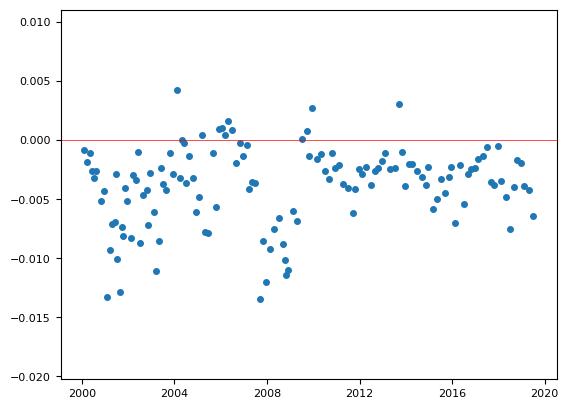

In [91]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (9,4)
plt.style.use('default')
plt.rcParams.update({'font.size': 8})
plt.rcParams['lines.markersize'] = 4

x = np.array(sent_df['date'])
y = np.array(sent_df['Average tone ratio'])

# fit = np.polyfit(x, y, 4)
# fit_fn = poly1d(fit)
# print(fit_fn)

# x_new = np.linspace(x[0], x[-1], 50)
# y_new = f(x_new)

plt.scatter(x, y)#, 'o', x_new, y_new)
# plt.plot(x, y, fit)
plt.axhline(y = 0, color = 'r', linestyle = '-', linewidth = 0.5)
plt.show
plt.savefig('Sentiment_scatter.png')

In [94]:
# summary statistics of the tone

sent_df['Average tone ratio'].describe()

count    135.000000
mean      -0.003858
std        0.003364
min       -0.013422
25%       -0.005773
50%       -0.003246
75%       -0.001805
max        0.004220
Name: Average tone ratio, dtype: float64

### Collecting Stockmarket data

In [95]:
path_omx = 'https://raw.githubusercontent.com/MatPiq/SDS-Group-35/master/Exam_Project/historic_data/omx30.csv'
cols = ['date', 'closing value']
omx = pd.read_csv(path_omx, sep=';', names = cols)

In [105]:
#opening value column
omx['opening value'] = omx['closing value'].shift(-1)
omx['date'] = pd.to_datetime(omx['date'])


#Difference between opening and closing value
omx['dif abs'] = omx['closing value'] - omx['opening value']
omx['dif frac'] = (omx['closing value']-omx['opening value']) / omx['opening value']
omx = omx.iloc[::-1]

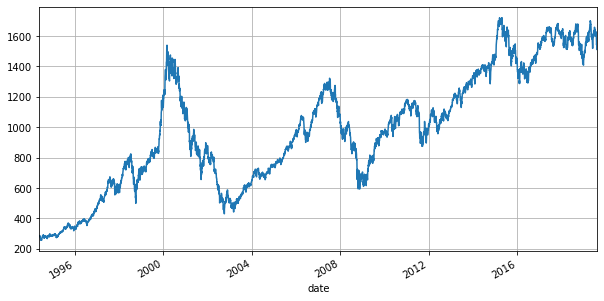

In [106]:
omx.drop(omx.loc[omx['closing value']==0].index, inplace=True)
omx.plot('date', 'closing value', grid = True, legend = False, figsize=(10, 5))
plt.savefig('omx.png')

### Collecting Repo data

In [98]:

#import repo
path_repo = 'https://raw.githubusercontent.com/MatPiq/SDS-Group-35/master/Exam_Project/historic_data/reporate.csv'
cols = ['date', 'repoann', 'repoeff']
repo = pd.read_csv(path_repo, sep=';', error_bad_lines=False, names = cols)
repo['date'] = pd.to_datetime(repo['date'])

In [99]:
#change in repo column
repo['repo_ch'] = repo['repoann']-repo['repoeff']

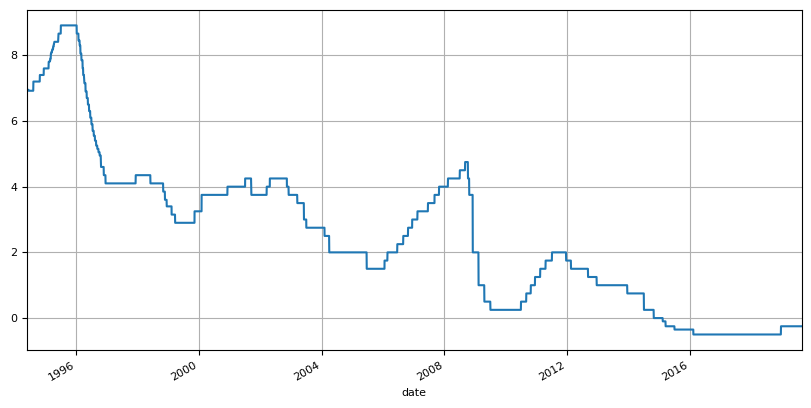

In [100]:
repo.plot('date', 'repoann', grid = True, legend = False, figsize=(10, 5))
plt.savefig('repo.png')

### Merging complete dataframe

In [107]:
#Necessary imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [108]:
#Merge repo and omx
repo_omx = pd.merge(repo, omx, on = 'date', how = 'inner')


In [109]:
#Inspect and drop NaN
nan_rows = repo_omx[repo_omx.isnull().T.any().T]
repo_omx.dropna()
repo_omx.head()

,date,repoann,repoeff,repo_ch,closing value,opening value,dif abs,dif frac
0,1994-06-01,6.95,6.95,0.0,283.35,282.32,1.03,0.003648
1,1994-06-02,6.95,6.95,0.0,282.32,284.12,-1.80,-0.006335
2,1994-06-03,6.95,6.95,0.0,284.12,286.71,-2.59,-0.009034
3,1994-06-06,6.95,6.95,0.0,286.71,282.07,4.64,0.016450
4,1994-06-07,6.95,6.95,0.0,282.07,283.50,-1.43,-0.005044


In [110]:
#merge repo_omx with sentiment analysis
complete_df = pd.merge(repo_omx, sent_df, on = 'date', how = 'inner')
complete_df.head()

,date,repoann,repoeff,repo_ch,closing value,opening value,dif abs,dif frac,Number of positive words,Number of negative words,Average tone ratio,Error in processing PDF
0,2000-02-04,3.75,3.25,0.5,1329.30,1349.28,-19.98,-0.014808,30,35,-0.000822,False
1,2000-03-23,3.75,3.75,0.0,1467.11,1478.75,-11.64,-0.007872,11,19,-0.001847,False
2,2000-05-05,3.75,3.75,0.0,1455.40,1444.37,11.03,0.007637,20,25,-0.001100,False
3,2000-06-08,3.75,3.75,0.0,1447.91,1439.05,8.86,0.006157,12,21,-0.002571,False
4,2000-07-07,3.75,3.75,0.0,1382.78,1380.42,2.36,0.001710,12,28,-0.003221,False


In [238]:
complete_df['dif frac'].describe(), complete_df['Average tone ratio'].describe(), complete_df['repo_ch'].describe()

(count    134.000000
 mean       0.001799
 std        0.013395
 min       -0.034643
 25%       -0.005243
 50%        0.001035
 75%        0.007185
 max        0.055853
 Name: dif frac, dtype: float64, count    134.000000
 mean      -0.003871
 std        0.003373
 min       -0.013422
 25%       -0.005809
 50%       -0.003254
 75%       -0.001784
 max        0.004220
 Name: Average tone ratio, dtype: float64, count    134.000000
 mean      -0.024254
 std        0.250693
 min       -1.750000
 25%        0.000000
 50%        0.000000
 75%        0.000000
 max        0.500000
 Name: repo_ch, dtype: float64)

[[1.         0.21641932]
 [0.21641932 1.        ]]


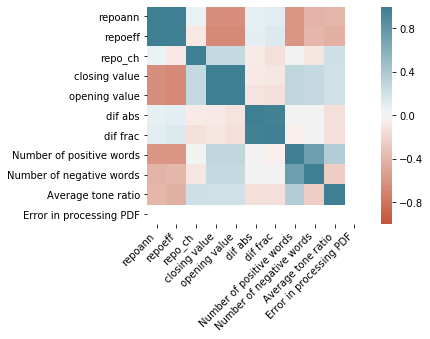

In [135]:
corr = complete_df.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

print(np.corrcoef(complete_df['Average tone ratio'],complete_df['repo_ch'])) # the correlation between sentiment index and
# change, if high, it means that the two variables capture a similar effect

### Dataframe quality assorance and validation

## Sentiment analysis

### Model validation

## Machine learning Model

In [224]:
import pandas as pd, numpy as np, sklearn

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error as mse
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [225]:
# slicing the data, we define two models that we want to compare and train different estimation techniques

X = complete_df.loc[ : , ['Average tone ratio', 'repoann']] # explanatory variables

Xs = complete_df.loc[ : , ['repoann']] # X_simple, the model uses only the repo rate announced to predict marke reactions

X_dumb = np.repeat(y_train.mean(), len(y), axis = None)

y = complete_df.loc[ : , ['dif frac']] # value to be predicted


In [226]:
X_dumb = X_dumb.reshape(-1, 1)

X_dumb#train

array([[0.00207546],
       [0.00207546],
       [0.00207546],
       [0.00207546],
       [0.00207546],
       [0.00207546],
       [0.00207546],
       [0.00207546],
       [0.00207546],
       [0.00207546],
       [0.00207546],
       [0.00207546],
       [0.00207546],
       [0.00207546],
       [0.00207546],
       [0.00207546],
       [0.00207546],
       [0.00207546],
       [0.00207546],
       [0.00207546],
       [0.00207546],
       [0.00207546],
       [0.00207546],
       [0.00207546],
       [0.00207546],
       [0.00207546],
       [0.00207546],
       [0.00207546],
       [0.00207546],
       [0.00207546],
       [0.00207546],
       [0.00207546],
       [0.00207546],
       [0.00207546],
       [0.00207546],
       [0.00207546],
       [0.00207546],
       [0.00207546],
       [0.00207546],
       [0.00207546],
       [0.00207546],
       [0.00207546],
       [0.00207546],
       [0.00207546],
       [0.00207546],
       [0.00207546],
       [0.00207546],
       [0.002

In [227]:
X = X.values
y = y.values
Xs = Xs.values
#X_dumb = X_dumb.values

In [228]:
# Linear regression

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=0) #split into training and test, random state to get the same output.

pipe_lr = make_pipeline(PolynomialFeatures(include_bias = False),  #including/excluding the bias depends on our choice
                        StandardScaler())
                        #LinearRegression())

test_mse = []
train_mse = []
parameters = []
degrees = range(2)

for p in degrees:
    X_train_p = pipe_lr.fit_transform(X_train, y_train) # polynomial expansion and transformation of the data
    X_test_p = pipe_lr.transform(X_test) # transform takes the test data and rescles it
    reg = LinearRegression().fit(X_train_p, y_train) 
    train_mse += [mse(reg.predict(X_train_p),y_train)] 
    test_mse += [mse(reg.predict(X_test_p),y_test)]     
    parameters.append(reg.coef_)
    
print(parameters)

[array([[ 3.41152369e-04,  7.77290964e-04,  3.11830490e-03,
        -2.54668624e-05, -7.11870940e-04]]), array([[ 3.41152369e-04,  7.77290964e-04,  3.11830490e-03,
        -2.54668624e-05, -7.11870940e-04]])]


In [162]:
train_mse, test_mse

([0.00014647856486526764, 0.00014647856486526764],
 [0.0002246662763774498, 0.0002246662763774498])

In [229]:
# create and split development set into validation and training

# splitting into development (2/3) and test data (1/3)
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=1/3, random_state=1)

# splitting development into train (1/3) and validation (1/3), so divide by half!
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=1/2, random_state=1)

# repeat the same for the simple model

# splitting into development (2/3) and test data (1/3)
Xs_dev, Xs_test, ys_dev, ys_test = train_test_split(Xs, y, test_size=1/3, random_state=1)

# splitting development into train (1/3) and validation (1/3), so divide by half!
Xs_train, Xs_val, ys_train, ys_val = train_test_split(Xs_dev, ys_dev, test_size=1/2, random_state=1)

# repeat for the dumb model

# splitting into development (2/3) and test data (1/3)
X_dumb_dev, X_dumb_test, y_dumb_dev, y_dumb_test = train_test_split(X_dumb, y, test_size=1/3, random_state=1)

# splitting development into train (1/3) and validation (1/3), so divide by half!
X_dumb_train, X_dumb_val, y_dumb_train, y_dumb_val = train_test_split(X_dumb_dev, y_dumb_dev, test_size=1/2, random_state=1)

In [233]:
#X_dumb_val

In [181]:
#PolynomialFeatures(include_bias=True).fit_transform(X)

array([[ 1.00000000e+00, -8.22368421e-04,  3.75000000e+00,
         6.76289820e-07, -3.08388158e-03,  1.40625000e+01],
       [ 1.00000000e+00, -1.84672207e-03,  3.75000000e+00,
         3.41038240e-06, -6.92520776e-03,  1.40625000e+01],
       [ 1.00000000e+00, -1.09962613e-03,  3.75000000e+00,
         1.20917762e-06, -4.12359798e-03,  1.40625000e+01],
       [ 1.00000000e+00, -2.57069409e-03,  3.75000000e+00,
         6.60846809e-06, -9.64010283e-03,  1.40625000e+01],
       [ 1.00000000e+00, -3.22126032e-03,  3.75000000e+00,
         1.03765180e-05, -1.20797262e-02,  1.40625000e+01],
       [ 1.00000000e+00, -2.57069409e-03,  3.75000000e+00,
         6.60846809e-06, -9.64010283e-03,  1.40625000e+01],
       [ 1.00000000e+00, -5.18902891e-03,  3.75000000e+00,
         2.69260210e-05, -1.94588584e-02,  1.40625000e+01],
       [ 1.00000000e+00, -4.30514896e-03,  4.00000000e+00,
         1.85343076e-05, -1.72205958e-02,  1.60000000e+01],
       [ 1.00000000e+00, -1.32955150e-02,  4.000

In [176]:
y_train.mean()

0.001395651952857122

In [234]:
# Lasso model: we remove the bias, i.e. beta_0 and we estimate a parameter that improves the prediction
pipe_lr = make_pipeline(PolynomialFeatures(include_bias = True),  #including/excluding the bias depends on our choice
                        StandardScaler(),
                        LinearRegression())

perform = []
lambdas = np.logspace(-4, 4, 20)
for lambda_ in lambdas:
    pipe_lasso = make_pipeline(PolynomialFeatures(include_bias= True), #multiple pipelines
                               StandardScaler(),
                               Lasso(alpha=lambda_, random_state=1))
    pipe_lasso.fit(X_train, y_train) # fit on training data
    y_pred = pipe_lasso.predict(X_val) # predict performance on validation set
    perform.append(np.sqrt(mse(y_pred, y_val))) # saved as a series of lambdas
    
hyperparam_perform = pd.Series(perform,index=lambdas)
hyperparam_perform.nsmallest(1) # select the smallest hyperparameter

optimal = hyperparam_perform.nsmallest(1)    
print('Optimal alpha:', optimal.index[0])
print('Validation MSE: %.3f' % optimal.values[0])

# insert optimal  lambda in new model

pipe_lasso = make_pipeline(PolynomialFeatures(include_bias=False), 
                           StandardScaler(),
                           Lasso(alpha=optimal.index[0])) # new value..., alpha is lambda!
# fit new model on all development data, fit = estimate!
pipe_lasso.fit(X_dev,y_dev)
pipe_lr.fit(X_dev,y_dev)

# compare model performance on test data
print('Lasso', round(np.sqrt(mse(pipe_lasso.predict(X_test),y_test)), 7)) # smaller mse, better performance than linear model
print('LinReg', round(np.sqrt(mse(pipe_lr.predict(X_test),y_test)), 7))

#--------------------------------------------
# REPEAT THE ANALYSIS FOR THE 'SIMPLE' MODEL
#--------------------------------------------

perform_s = []
lambdas = np.logspace(-4, 4, 20)
for lambda_ in lambdas:
    pipe_lasso = make_pipeline(PolynomialFeatures(include_bias= True), #multiple pipelines
                               StandardScaler(),
                               Lasso(alpha=lambda_, random_state=1))
    pipe_lasso.fit(Xs_train, ys_train) # fit on training data
    ys_pred = pipe_lasso.predict(Xs_val) # predict performance on validation set
    perform_s.append(np.sqrt(mse(ys_pred, ys_val))) # saved as a series of lambdas
    
hyperparam_perform_s = pd.Series(perform_s,index=lambdas)
hyperparam_perform_s.nsmallest(1) # select the smallest hyperparameter

optimal_s = hyperparam_perform_s.nsmallest(1)    
print('Optimal alpha univariate model:', optimal_s.index[0])
print('Validation RMSE univariate model: %.3f' % optimal_s.values[0])

# insert optimal  lambda in new model

pipe_lasso_s = make_pipeline(PolynomialFeatures(include_bias=True), 
                           StandardScaler(),
                           Lasso(alpha=optimal_s.index[0])) # new value..., alpha is lambda!
# fit new model on all development data, fit = estimate!
pipe_lasso_s.fit(Xs_dev,ys_dev)
pipe_lr.fit(Xs_dev,ys_dev)

# compare model performance on test data
print('Lasso univariate model', round(np.sqrt(mse(pipe_lasso_s.predict(Xs_test), ys_test)), 6)) # smaller mse, better performance than linear model
print('LinReg univariate model', round(np.sqrt(mse(pipe_lr.predict(Xs_test), ys_test)), 6))

# -------------------------
# Repeat for dumb model
# -------------------------

#X_dumb_train = X_dumb_train.reshape(-1,1)

perform_dumb = []
lambdas = np.logspace(-4, 4, 20)
for lambda_ in lambdas:
    pipe_lasso = make_pipeline(PolynomialFeatures(include_bias= False), #multiple pipelines
                               StandardScaler(),
                               Lasso(alpha=lambda_, random_state=1))
    pipe_lasso.fit(X_dumb_train, y_dumb_train) # fit on training data
    y_dumb_pred = pipe_lasso.predict(X_dumb_val) # predict performance on validation set
    perform_dumb.append(np.sqrt(mse(y_dumb_pred, y_dumb_val))) # saved as a series of lambdas
    
hyperparam_perform_dumb = pd.Series(perform_dumb,index=lambdas)
hyperparam_perform_dumb.nsmallest(1) # select the smallest hyperparameter

optimal_dumb = hyperparam_perform_dumb.nsmallest(1)    
print('Optimal alpha simple model:', optimal_dumb.index[0])
print('Validation RMSE simple model: %.3f' % optimal_dumb.values[0])

# insert optimal  lambda in new model

pipe_lasso_dumb = make_pipeline(PolynomialFeatures(include_bias=False), 
                           StandardScaler(),
                           Lasso(alpha=optimal_dumb.index[0])) # new value..., alpha is lambda!
# fit new model on all development data, fit = estimate!
pipe_lasso_dumb.fit(X_dumb_dev,y_dumb_dev)
pipe_lr.fit(X_dumb_dev,y_dumb_dev)

# compare model performance on test data
print('Lasso simple model', round(np.sqrt(mse(pipe_lasso_dumb.predict(X_dumb_test),y_dumb_test)), 6)) # smaller mse, better performance than linear model
print('LinReg simple model', round(np.sqrt(mse(pipe_lr.predict(X_dumb_test),y_dumb_test)), 6))


Optimal alpha: 0.0018329807108324356
Validation MSE: 0.014
Lasso 0.0127374
LinReg 0.0122651
Optimal alpha univariate model: 0.0018329807108324356
Validation RMSE univariate model: 0.014
Lasso univariate model 0.012858
LinReg univariate model 0.012671
Optimal alpha simple model: 0.0001
Validation RMSE simple model: 0.014
Lasso simple model 0.012883
LinReg simple model 0.012883


In [165]:
#perform_s

[0.0001971591836115559,
 0.0001958464468889803,
 0.00019441818741148384,
 0.00019267236616863883,
 0.00019442168981209602,
 0.00019442168981209602,
 0.00019442168981209602,
 0.00019442168981209602,
 0.00019442168981209602,
 0.00019442168981209602,
 0.00019442168981209602,
 0.00019442168981209602,
 0.00019442168981209602,
 0.00019442168981209602,
 0.00019442168981209602,
 0.00019442168981209602,
 0.00019442168981209602,
 0.00019442168981209602,
 0.00019442168981209602,
 0.00019442168981209602]

### Model validation

In [154]:
pipe_lasso.fit(X_dev, y_dev)
pipe_lasso.predict(X_test)

array([0.00238817, 0.00238817, 0.00238817, 0.00238817, 0.00238817,
       0.00238817, 0.00238817, 0.00238817, 0.00238817, 0.00238817,
       0.00238817, 0.00238817, 0.00238817, 0.00238817, 0.00238817,
       0.00238817, 0.00238817, 0.00238817, 0.00238817, 0.00238817,
       0.00238817, 0.00238817, 0.00238817, 0.00238817, 0.00238817,
       0.00238817, 0.00238817, 0.00238817, 0.00238817, 0.00238817,
       0.00238817, 0.00238817, 0.00238817, 0.00238817, 0.00238817,
       0.00238817, 0.00238817, 0.00238817, 0.00238817, 0.00238817,
       0.00238817, 0.00238817, 0.00238817, 0.00238817, 0.00238817])

In [168]:
# Measures for accuracy r2_score??
from sklearn.metrics import r2_score

pipe_lasso.fit(X_dev, y_dev)
#pipe_lasso.predict(X_test)

y_pred = pipe_lasso.predict(X_test)

print(r2_score(y_test, y_pred))



-0.018899367178471183


In [169]:
pipe_lasso.fit(Xs_dev, ys_dev)
#pipe_lasso.predict(Xs_test)

ys_pred = pipe_lasso.predict(Xs_test)

print(r2_score(ys_test, ys_pred))


-0.018899367178471183


In [ ]:
from sklearn.model_selection import validation_curve

train_scores, test_scores = \
    validation_curve(estimator=pipe_lasso,
                     X=X_train,
                     y=y_train,
                     param_name='lasso__alpha',
                     param_range=lambdas,
                     scoring='neg_mean_squared_error',                 
                     cv=3)

mse_score = pd.DataFrame({'Train':-train_scores.mean(axis=1),
                          'Validation':-test_scores.mean(axis=1),
                          'lambda':lambdas})\
              .set_index('lambda')   
print(mse_score.Validation.nsmallest(1))

mse_score.plot(logx=True, logy=True) # optimal hyperparameters